# Projeto 3

##### Bibliotecas

In [1]:
# !pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping

2024-04-22 17:37:53.820671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 17:37:55.129190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
data = pd.read_csv("./data/faults.csv")

## Análise exploratório e Transformação dos Dados

### Questionamentos
### 2)

- ##### i) A base de dados é consistente? **Sim**
- ##### ii) Há dados faltantes? **Não**
- ##### iii) Há dados não numéricos? **Não**
- ##### iv) A base de dados é balanceada? **Não. Será aplicado balanceamento**
- ##### v) As variáveis assumem valores plausíveis? Como é a distribuição dos dados? Há *outlier*? ***A grande maioria, no entanto algumas apresentam outliers que serão removidos**
- ##### vi) Há necessidade de normallizar ou padronizar as variáveis de entrada? Justifique? **Sim, poís estão em escala diferentes**
- ##### vii) Analise o heatmap das variaveis e proponha uma estratégia para reduzir as variáveis de entrada sem perda de informação útil para o classificador. **Será aplicado Principal Component Analysis (PCA) para eliminar a correção das variáveis**


#### Amostra

In [4]:
data.sample(3)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
1383,435,729,4737382,4737394,1851,304,87,201109,91,132,...,-0.9592,-0.1512,1.0000,0,0,0,0,0,0,1
582,43,200,696884,696948,6059,206,129,626256,45,125,...,-0.5924,-0.1925,1.0000,0,0,1,0,0,0,0
216,144,164,936743,936828,1148,85,94,121595,89,132,...,0.7647,-0.1725,0.9999,0,1,0,0,0,0,0


#### Informações Gerais

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

In [6]:
data.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,...,0.083288,-0.131305,0.585420,0.081401,0.097888,0.201443,0.037094,0.028336,0.207110,0.346728
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,...,0.500868,0.148767,0.339452,0.273521,0.297239,0.401181,0.189042,0.165973,0.405339,0.476051
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,...,-0.333300,-0.195000,0.248200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,...,0.095200,-0.133000,0.506300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,...,0.511600,-0.066600,0.999800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dados faltantes

In [7]:
data.isna().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

#### Distribuição dados (consistência e outliers)

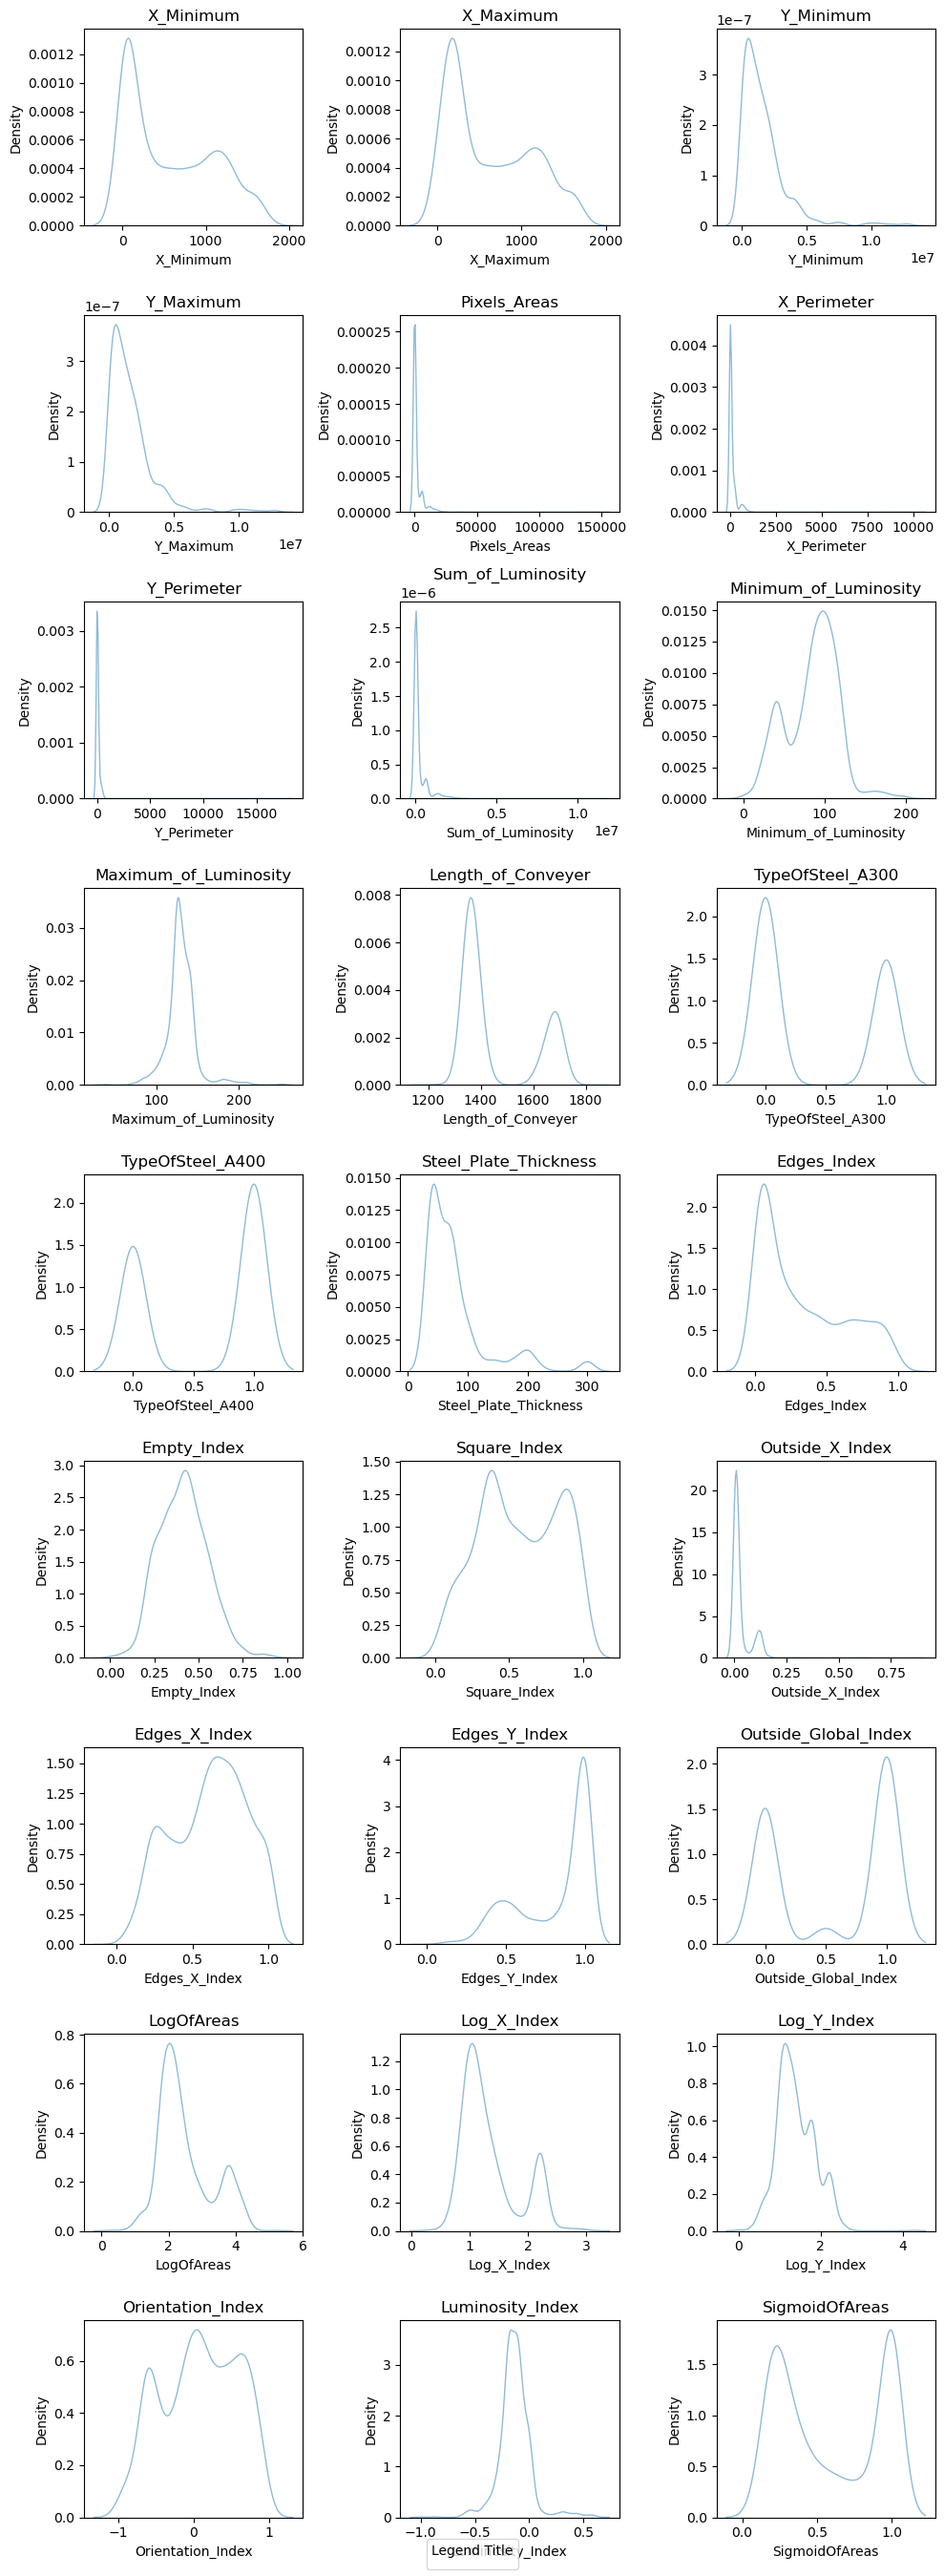

In [8]:
fig, axes = plt.subplots(9, 3, figsize=(10, 27))
fig.set
# Loop para criar os KDE plots
for i, ax in enumerate(axes.flat):
    sns.kdeplot(data=data, x=data.columns[i], ax=ax,
                alpha=.5, linewidth=1, common_norm=True, legend=False)

    ax.set_title(f'{data.columns[i]}')

plt.tight_layout()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, title="Legend Title")
plt.show()


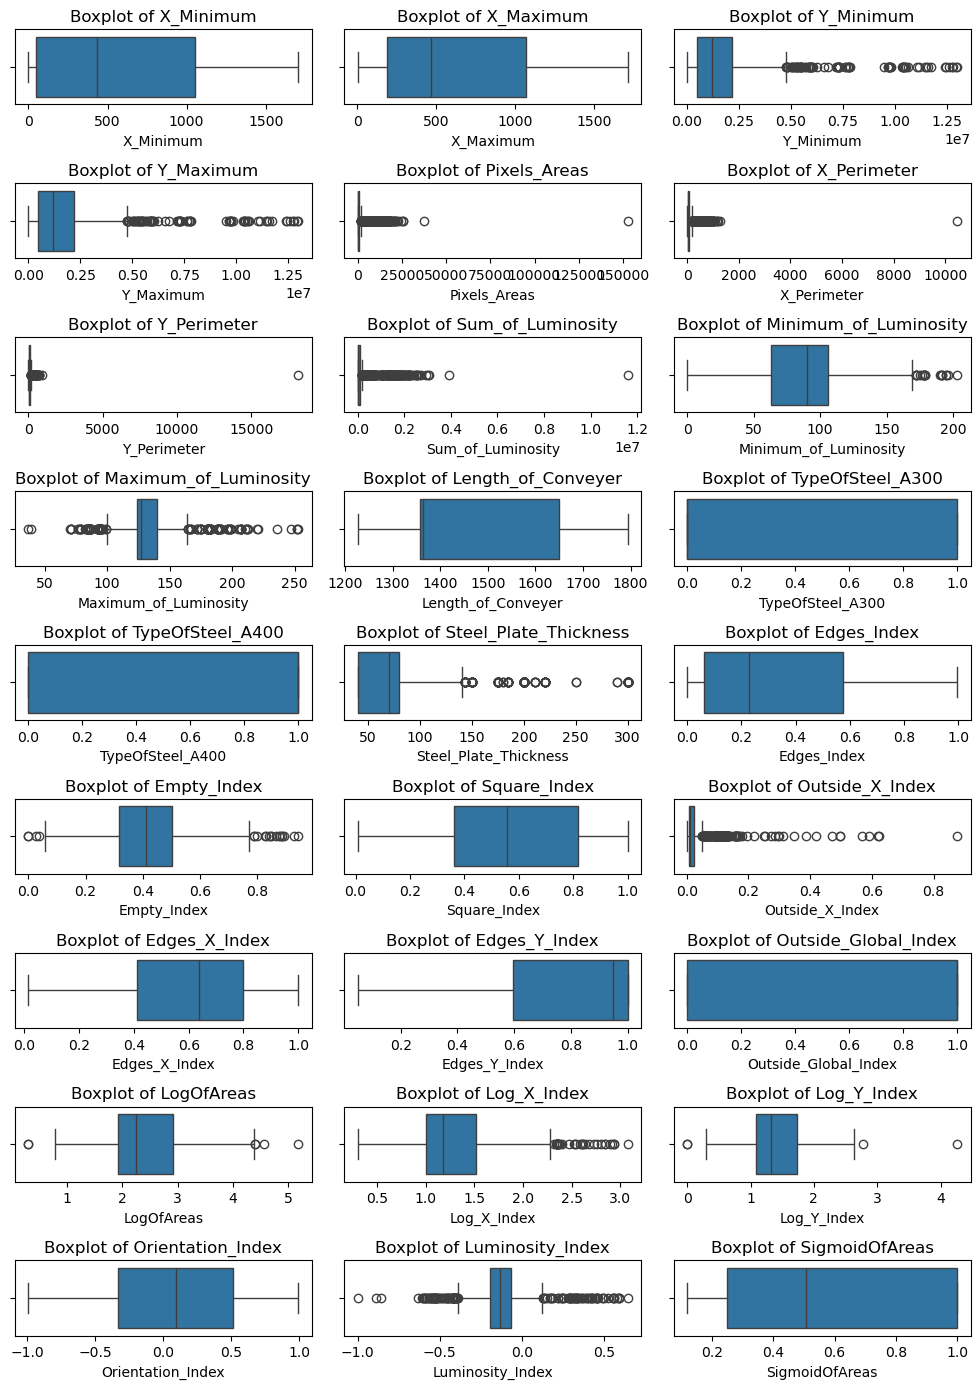

In [9]:
# Configurando a área de plotagem
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(10, 14))

for i, ax in enumerate(axes.flat):
    sns.boxplot(data=data, x=data.columns[i], ax=ax, legend=False)
    ax.set_title(f'Boxplot of {data.columns[i]}')

plt.tight_layout()
plt.show()

#### Eliminação de Outliers

In [10]:
lof = LocalOutlierFactor(contamination=0.1)

outliers = lof.fit_predict(data)
filtered_data = data[outliers == 1]

#### Validação da remoção de Outliers

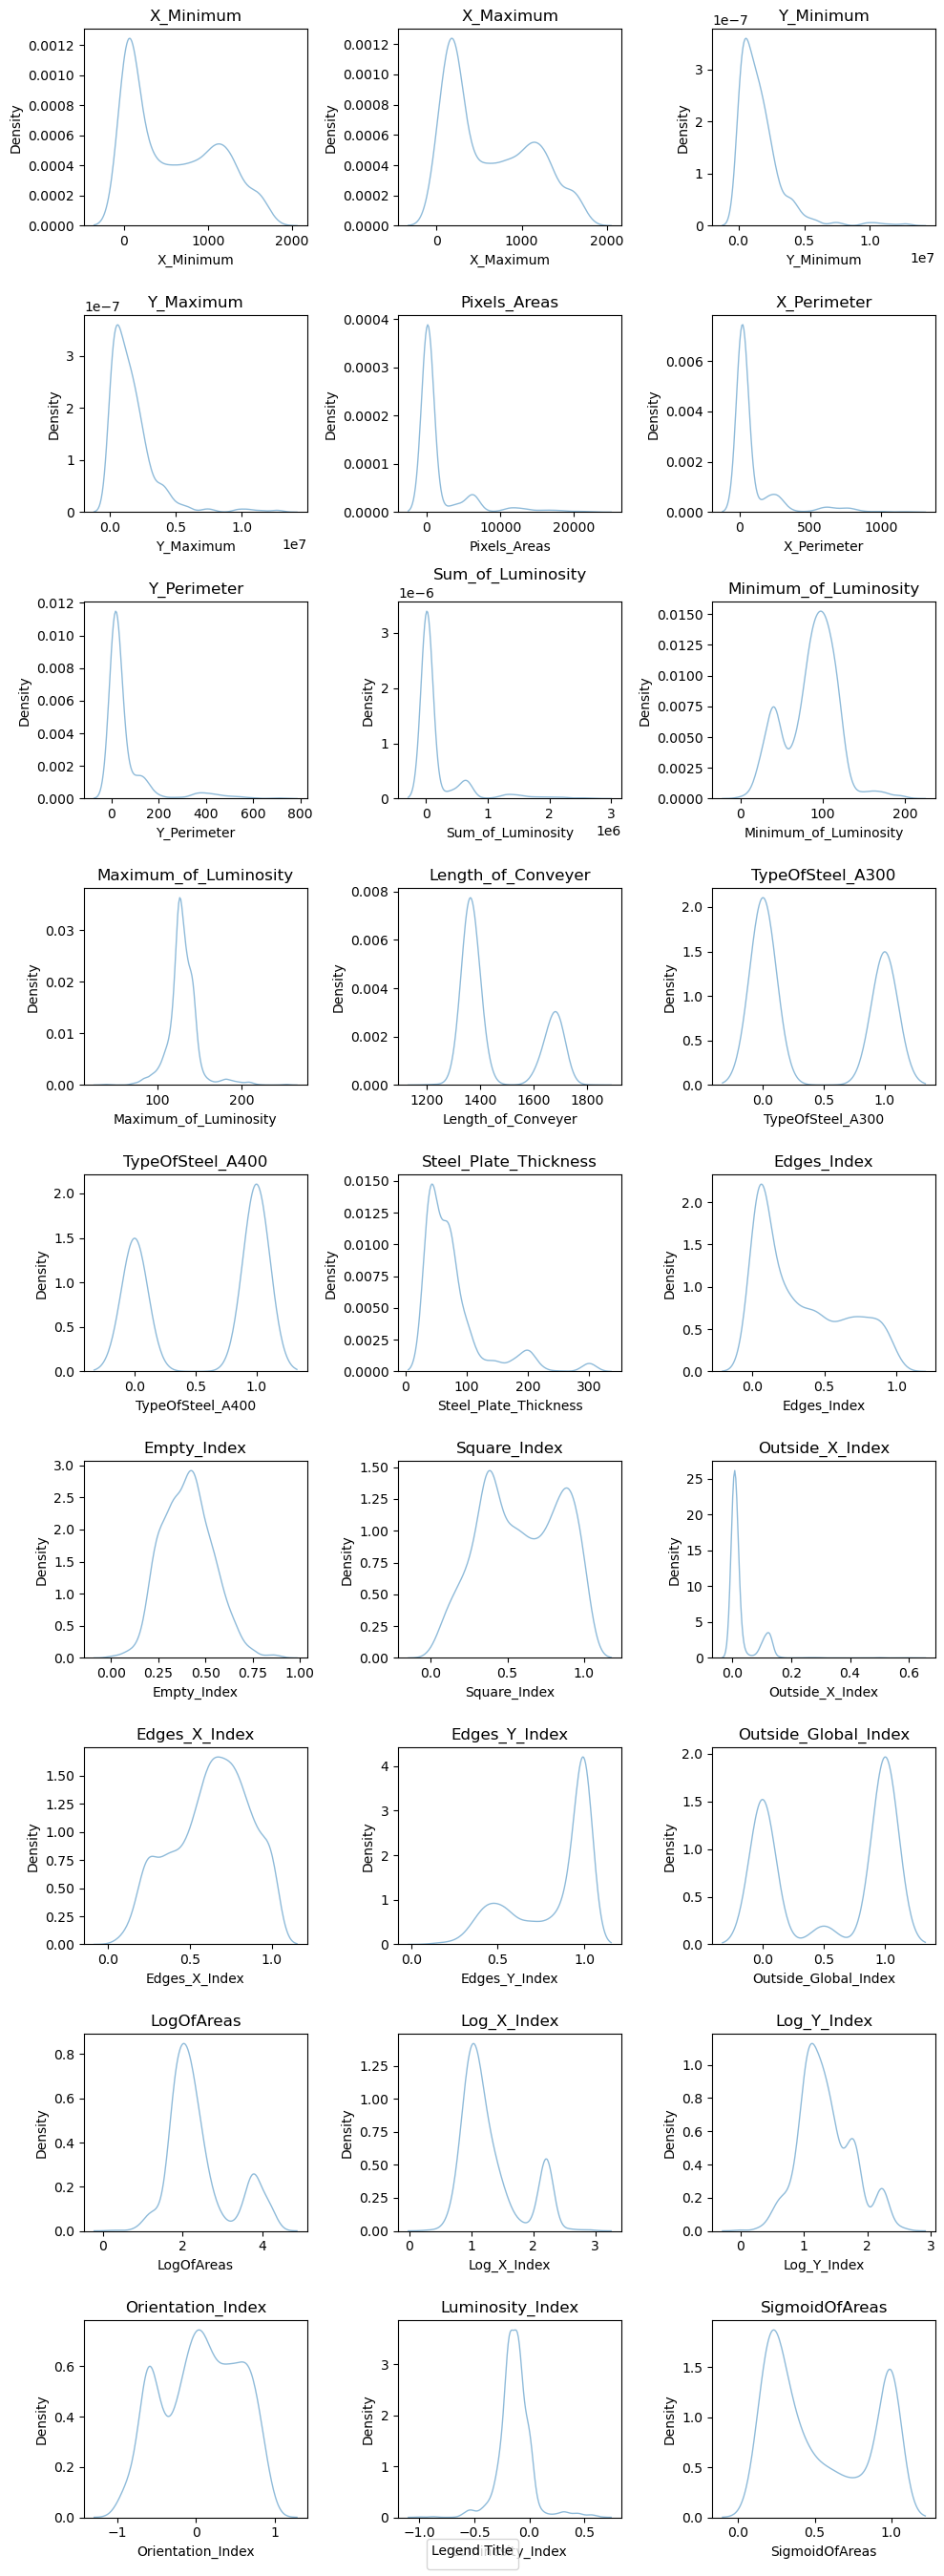

In [11]:
fig, axes = plt.subplots(9, 3, figsize=(10, 27))
fig.set
# Loop para criar os KDE plots
for i, ax in enumerate(axes.flat):
    sns.kdeplot(data=filtered_data, x=filtered_data.columns[i], ax=ax,
                alpha=.5, linewidth=1, common_norm=True, legend=False)

    ax.set_title(f'{filtered_data.columns[i]}')

plt.tight_layout()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, title="Legend Title")
plt.show()


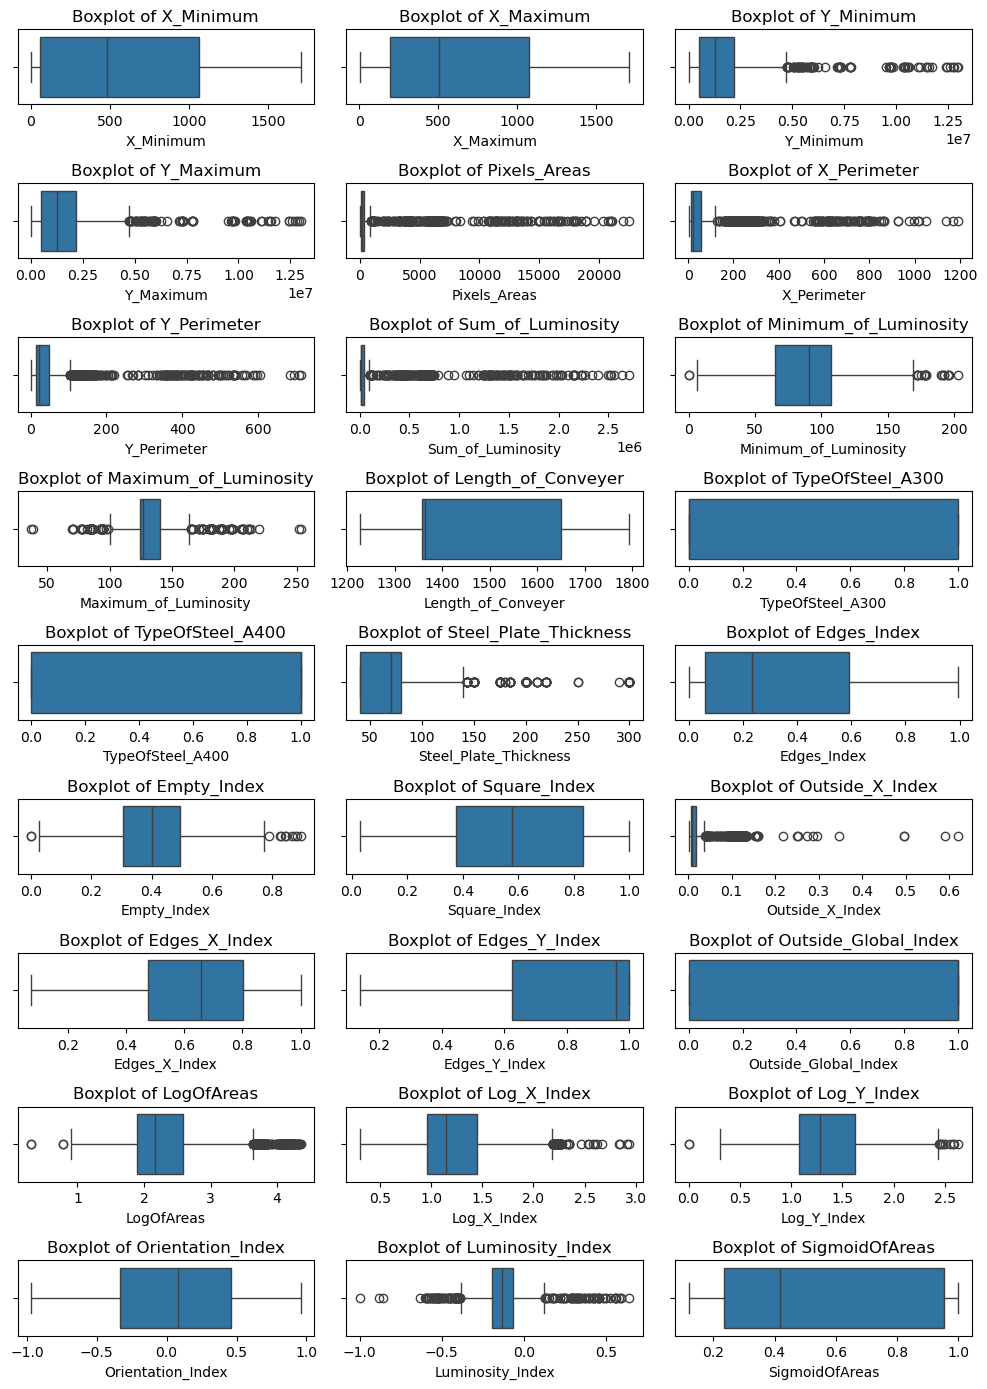

In [12]:
# Configurando a área de plotagem
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(10, 14))

for i, ax in enumerate(axes.flat):
    sns.boxplot(data=filtered_data, x=filtered_data.columns[i], ax=ax, legend=False)
    ax.set_title(f'Boxplot of {filtered_data.columns[i]}')

plt.tight_layout()
plt.show()

### Balanceamento de Classes

In [13]:
print('Distribuição original das classes:', Counter(np.argmax(filtered_data.iloc[:, 27:].values, axis=1)))

Distribuição original das classes: Counter({6: 604, 5: 386, 2: 337, 1: 165, 0: 137, 3: 72, 4: 46})


In [14]:
smote = SMOTE(random_state=25)
X_res, y_res = smote.fit_resample(filtered_data.iloc[:, :27].values, np.argmax(filtered_data.iloc[:, 27:].values, axis=1))

encoder = OneHotEncoder(sparse_output=False)
target = encoder.fit_transform(y_res.reshape(-1, 1))

filtered_balanced_data = pd.DataFrame(X_res, columns=filtered_data.iloc[:, :27].columns)

print('Nova distribuição das classes:', Counter(y_res))

Nova distribuição das classes: Counter({0: 604, 1: 604, 2: 604, 3: 604, 4: 604, 5: 604, 6: 604})


### Transformação de escala

In [15]:
scaler = MinMaxScaler()
_filtered_balanced_scaled_data = scaler.fit_transform(filtered_balanced_data)
filtered_balanced_scaled_data = pd.DataFrame(_filtered_balanced_scaled_data, columns=filtered_balanced_data.columns)

In [16]:
filtered_balanced_scaled_data.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,...,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000,4228.000000
mean,0.366320,0.382125,0.130276,0.130277,0.054866,0.060482,0.073983,0.050439,0.442846,0.431880,...,0.035011,0.590186,0.841832,0.584024,0.481289,0.334752,0.494931,0.572273,0.535579,0.425634
std,0.286979,0.274146,0.130651,0.130651,0.142693,0.129826,0.132883,0.136252,0.142040,0.073115,...,0.068923,0.259535,0.231728,0.461180,0.186913,0.166999,0.167217,0.257312,0.080258,0.359793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.070527,0.121709,0.048677,0.048677,0.003015,0.009644,0.015072,0.002805,0.374672,0.402778,...,0.006467,0.384466,0.765753,0.000000,0.378555,0.228284,0.387476,0.361906,0.493236,0.115679
50%,0.360996,0.362047,0.106084,0.106085,0.005893,0.015687,0.029208,0.005385,0.472906,0.428037,...,0.010333,0.610754,0.977585,1.000000,0.445733,0.280720,0.486309,0.573164,0.537413,0.283320
75%,0.616807,0.621416,0.161399,0.161399,0.014355,0.033585,0.060043,0.012383,0.541989,0.476852,...,0.019344,0.795955,1.000000,1.000000,0.541299,0.370692,0.601521,0.814458,0.576813,0.776765
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Eliminação de Correlação com PCA

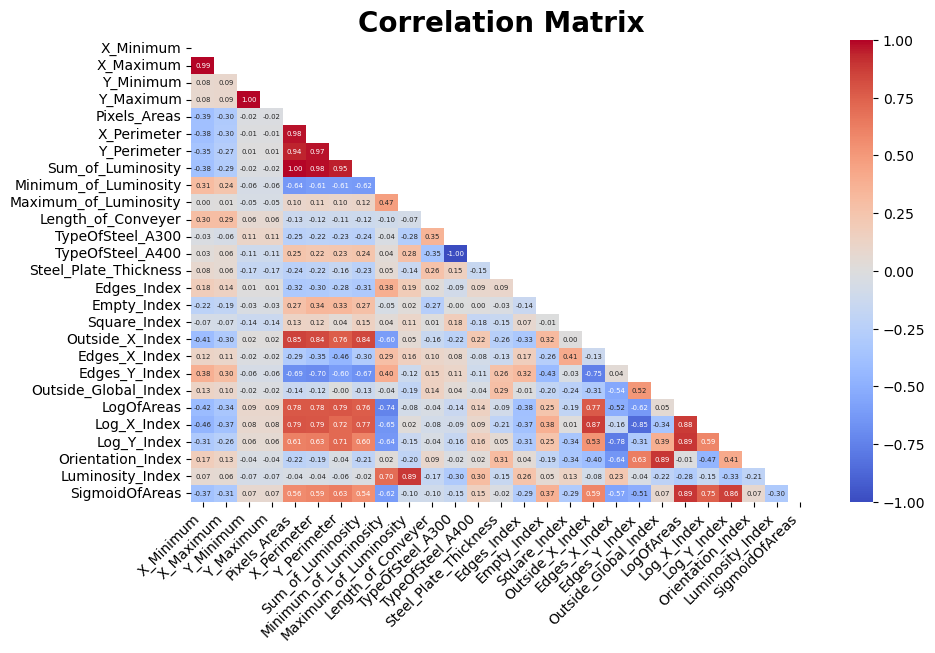

In [17]:
correlation_matrix = filtered_balanced_scaled_data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 6), dpi=100) 
plt.title("Correlation Matrix", fontsize=20, fontweight='bold')
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, mask=mask, annot_kws={'size': 5})
plt.xticks(rotation=45, ha='right')
plt.show()

In [18]:
pca = PCA(n_components=filtered_balanced_scaled_data.shape[1])
_filtered_balanced_scaled_pca_data = pca.fit_transform(filtered_balanced_scaled_data)

filtered_balanced_scaled_pca_data = pd.DataFrame(data=_filtered_balanced_scaled_pca_data, columns=filtered_balanced_scaled_data.columns)

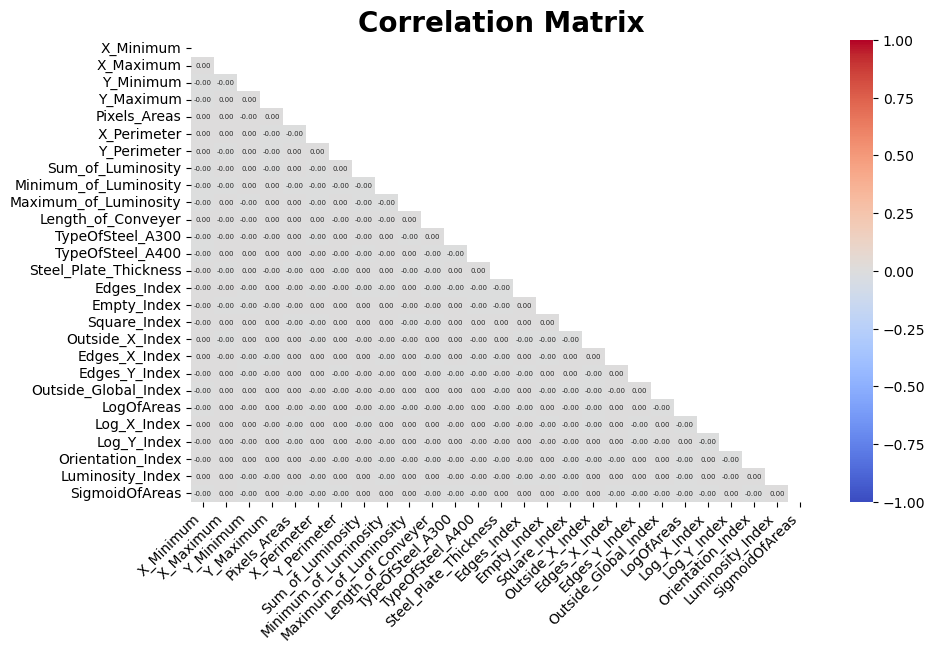

In [19]:
correlation_matrix = filtered_balanced_scaled_pca_data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 6), dpi=100)  # Tamanho da figura
plt.title("Correlation Matrix", fontsize=20, fontweight='bold')
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, mask=mask, annot_kws={'size': 5})
plt.xticks(rotation=45, ha='right')
plt.show()

### 3) Particione aleatoriamente 70% das amostras para treinar a rede neural MLP  e o restante das amostras para validar o sistema. 

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(filtered_balanced_scaled_pca_data.values, target, test_size=0.3, random_state=25)

### 4) Implemente uma rede neural MLP capaz de receber as variáveis de entrada que descrevem a geometria do defeito na placa e indicar a probabilidade de existência de cada possível fala

##### Modelo

In [21]:
model = Sequential()

##############   INPUT    ##############
model.add(Input(shape=(27,)))

############## 1ST LAYERS ##############
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

############## 2ND LAYERS ##############
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

############## 3TH LAYERS ##############
model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

##############   OUTPUT   ##############
model.add(Dense(7, activation='softmax'))

2024-04-22 17:38:34.337626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 17:38:34.409690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 17:38:34.409807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 17:38:34.422381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 17:38:34.422769: I tensorflow/compile

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                896       
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [23]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy())

##### Treinamento

In [24]:
earlyStopping = EarlyStopping(
    restore_best_weights=True,
    verbose=2,
    patience=50,
    monitor='val_loss'
)

In [25]:
history = model.fit(X_train, y_train, epochs=1_000_000, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[earlyStopping], verbose=0)

2024-04-22 17:38:42.774251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-22 17:38:42.791434: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa4e0b0a8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 17:38:42.791490: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-04-22 17:38:42.824074: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-22 17:38:46.662784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-22 17:38:46.868234: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-22 17:38:47.00710

Restoring model weights from the end of the best epoch: 156.
Epoch 206: early stopping


[]

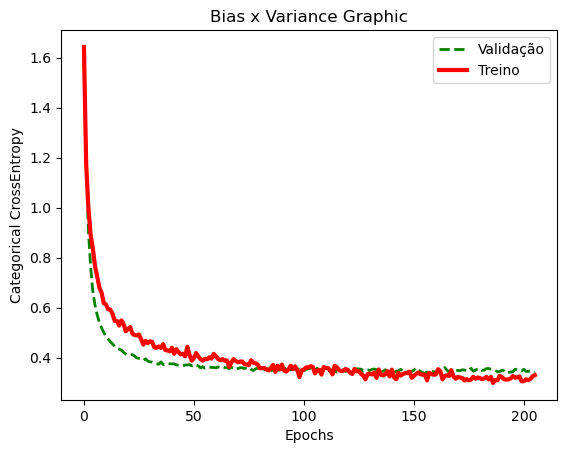

In [26]:
sns.lineplot(data=history.history['val_loss'], label="Validação", linestyle="--", linewidth=2, color='g')
sns.lineplot(data=history.history['loss'], label="Treino", linestyle="-", linewidth=3, color='r')

plt.title("Bias x Variance Graphic")
plt.xlabel("Epochs")
plt.ylabel("Categorical CrossEntropy")
plt.plot()

In [27]:
y_pred = model.predict(X_valid, verbose=0)
classes_name = filtered_data.columns[27:]
classes = [f"P({_class})" for _class in classes_name]
result = pd.DataFrame(y_pred, columns=classes)
result['real'] = np.argmax(y_valid, axis=1)
result['predict'] = np.argmax(y_pred, axis=1)

result['real'] = result.apply(lambda row: classes_name[int(row['real'])], axis=1)
result['predict'] = result.apply(lambda row: classes_name[int(row['predict'])], axis=1)

In [28]:
result.sample(10)

,P(Pastry),P(Z_Scratch),P(K_Scatch),P(Stains),P(Dirtiness),P(Bumps),P(Other_Faults),real,predict
765,2.804575e-02,5.650450e-02,1.005036e-03,1.926294e-03,4.442834e-03,7.286807e-01,0.179395,Bumps,Bumps
169,6.783025e-01,2.778106e-07,3.778574e-05,1.061846e-09,5.652043e-06,9.531891e-04,0.320701,Other_Faults,Pastry
305,3.520547e-06,9.959742e-01,2.850981e-07,2.406081e-10,1.613820e-10,1.056825e-03,0.002965,Z_Scratch,Z_Scratch
1261,1.124756e-05,9.992877e-01,1.143396e-05,1.908118e-10,9.774034e-10,9.563482e-05,0.000594,Z_Scratch,Z_Scratch
1229,1.166334e-04,1.112648e-03,1.051794e-02,4.996600e-04,5.428277e-05,2.373281e-01,0.750371,Other_Faults,Other_Faults
927,4.253989e-07,2.346592e-08,9.999465e-01,1.516601e-10,1.069197e-11,1.771598e-08,0.000053,K_Scatch,K_Scatch
913,2.910375e-05,9.778095e-01,2.470781e-05,2.211189e-09,2.066325e-09,7.773308e-03,0.014363,Z_Scratch,Z_Scratch
771,1.918732e-06,2.236287e-06,9.979509e-01,9.059598e-10,1.132449e-09,1.465925e-05,0.002030,K_Scatch,K_Scatch
282,1.322101e-06,9.288048e-05,9.973987e-01,1.010156e-10,1.492100e-09,2.336937e-05,0.002484,K_Scatch,K_Scatch
469,4.349266e-07,8.528132e-10,3.518798e-06,9.998684e-01,3.498712e-09,4.174412e-05,0.000086,Stains,Stains


In [29]:
matrix = confusion_matrix(np.argmax(y_valid, axis=1), np.argmax(y_pred, axis=1))

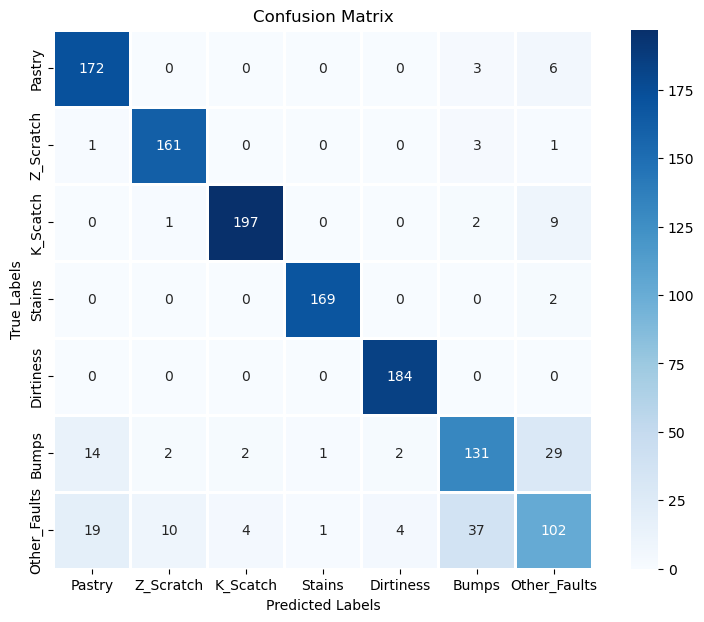

In [30]:
plt.figure(figsize=(10, 7))  # Ajuste o tamanho da figura conforme necessário
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', square=True, linewidths=0.8, xticklabels=classes_name, yticklabels=classes_name)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Questionamentos
### 5) Apresente o resultado fazendo considerações sobre:

- ##### i) Como a complexidade do modelo impacta no desempenho?
    **Modelos complexos tendem a apresentar menor erro de Bias, por conseguir reter melhor os possiveis padrões nos dados. No entanto, o excesso de complexidade pode causar no modelo overfitting.**


- ##### ii) Comente sobre a estratégia de ajuste dos hiper-parâmetros adotada para ajustar o modelo.
    **A quantidade ideal de epochs foi obtido com a CallBack de EarlyStopping que interrompe o treinamento após a métrica de loss em dados de validação se afasta do mínimo atingido. Os demais parâmetros foram obtidos de forma heuristica.**

- ##### iii) Como a quantidade de amostras de cada classe pode influenciar no desempenho da rede neural?
    **Quanto mais dado se tem, melhor se consegue extrair informação. Modelos treinados com poucos dados tendem a incorrer no classico erro "Maldição da Dimensionalidade", como é conhecido na literatura. É possivel ter indícios dessa ocorrência quando se observa grande variância entre dados de validação e teste, assumindo que partam da mesma população amostral.**

- ##### iv) Quais variáveis de entrada são mais relevantes para o problema?
    **Dado que Redes Neurais Artificiais são algoritmos "caixa-preta", não se pode assumir com precisão a feature que mais contribui com a performance do modelo, pois, por exemplo, se a relação não linear entre duas features de baixa corelação com a variável-alvo contribuir significativamente com o aprendizado, tampouco o modelo quanto a matriz de correlação explicitarão essa relação. Para fins de simplificação, assumindo que as relações lineares desse problema prepondere, e de posse da matriz de correlação já gerada, podemos inferir que as features ____ são mais relevantes.**
